<a href="https://colab.research.google.com/github/vagnerpereirablue/testecolab/blob/main/testeprophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install influxdb
!pip install prophet 


In [ ]:
!pip install prophet


In [6]:
# importar as bibliotecas
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# importar prophet e bibliotecas de validação
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

# melhorar a resolução dos gráficos
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [73]:
from influxdb import InfluxDBClient
from datetime import datetime
from random import randrange, uniform
import random
import string
import time
import pandas as pd 

db_influx = InfluxDBClient(host='52.226.69.167', port=8086, username='admin', password='adminInfluxBit', ssl=True, verify_ssl=False)
db_influx.switch_database('dbBitSaas')
df = pd.DataFrame(db_influx.query("SELECT * FROM measMLMinuto WHERE time> now() - 10d").get_points())
#print(df)
df.to_csv('novos_fake2_measML.csv')

In [74]:
df.tail()

time alarmValue nmDevice nmEquipament  \
919  2022-12-28T19:24:43.981443Z      False   device          PTZ   
920  2022-12-28T19:24:52.148462Z      False   device          PTZ   
921  2022-12-28T19:25:00.315353Z      False   device          PTZ   
922  2022-12-28T19:25:08.481185Z      False   device          PTZ   
923  2022-12-28T19:25:16.649963Z      False   device          PTZ   

         nmSensor tagId tpCollector   tpSensor  value  
919  Tag_Test_Ptz    13      Modbus  Teste_PTZ     22  
920  Tag_Test_Ptz    13      Modbus  Teste_PTZ     27  
921  Tag_Test_Ptz    13      Modbus  Teste_PTZ     27  
922  Tag_Test_Ptz    13      Modbus  Teste_PTZ     20  
923  Tag_Test_Ptz    13      Modbus  Teste_PTZ     23

In [42]:
df1 = pd.read_csv('/content/Delhi_NCR_1990_2022_Safdarjung.csv')

In [43]:
df1.head()

time  tavg  tmin  tmax  prcp
0  01-01-1990   9.4   6.0  15.1   0.0
1  02-01-1990   9.3   5.2  14.2   0.0
2  03-01-1990   9.0   6.5  13.6   0.0
3  04-01-1990  10.7   6.0  17.5   0.0
4  05-01-1990  12.6   7.3  20.8   0.0

In [44]:
df1.tail()

time  tavg  tmin  tmax  prcp
11889  21-07-2022  28.6  26.8  30.6  21.2
11890  22-07-2022  29.3  27.0  32.9   0.3
11891  23-07-2022  30.1  25.5  34.9   8.9
11892  24-07-2022  30.6  27.1  35.7   0.0
11893  25-07-2022  30.7  26.8  35.7   0.0

In [45]:
df1.time = pd.to_datetime(df1.time).dt.tz_localize(None) #testdata['time'].dt.tz_localize(None)

In [46]:
df1.head()

time  tavg  tmin  tmax  prcp
0 1990-01-01   9.4   6.0  15.1   0.0
1 1990-02-01   9.3   5.2  14.2   0.0
2 1990-03-01   9.0   6.5  13.6   0.0
3 1990-04-01  10.7   6.0  17.5   0.0
4 1990-05-01  12.6   7.3  20.8   0.0

In [47]:
df1.describe()

tavg          tmin          tmax         prcp
count  11800.000000  10358.000000  11361.000000  5754.000000
mean      24.996415     18.877563     31.788232     3.662478
std        7.326116      7.786944      6.838998    12.473498
min        6.600000      0.100000      9.800000     0.000000
25%       18.500000     11.800000     26.700000     0.000000
50%       27.000000     20.000000     33.200000     0.000000
75%       30.900000     26.000000     36.600000     0.500000
max       39.800000     34.200000     48.100000   262.900000

In [48]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11894 entries, 0 to 11893
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    11894 non-null  datetime64[ns]
 1   tavg    11800 non-null  float64       
 2   tmin    10358 non-null  float64       
 3   tmax    11361 non-null  float64       
 4   prcp    5754 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 464.7 KB


In [49]:
# verificar se há dados ausentes
df1.isnull().sum()

time       0
tavg      94
tmin    1536
tmax     533
prcp    6140
dtype: int64

In [50]:
# ver as datas mínimas e máximas
df1.index.min(),df1.index.max()

(0, 11893)

In [52]:
df_limpo = df1[['time', 'tmax']]
df_limpo = df1.set_index('time').sort_index()


In [53]:
# ver as datas mínimas e máximas
df_limpo.index.min(), df_limpo.index.max()

(Timestamp('1990-01-01 00:00:00'), Timestamp('2022-12-07 00:00:00'))

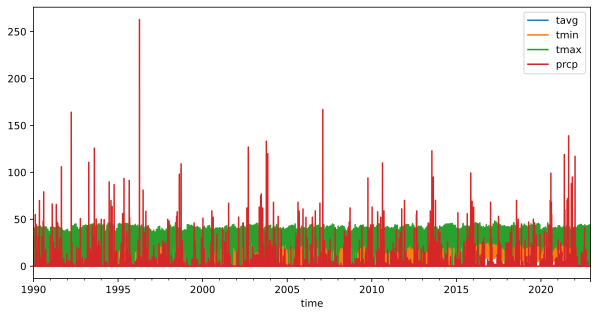

In [54]:
# plotar gráfico diário
fig, ax = plt.subplots(figsize=(10, 5))
df_limpo.resample('D').sum().plot(ax=ax)
plt.show()

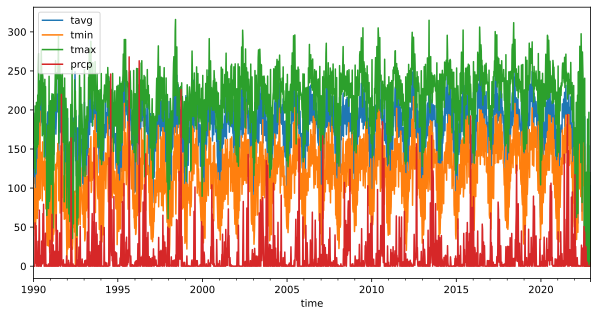

In [55]:
# plotar gráfico semanal
fig, ax = plt.subplots(figsize=(10, 5))
df_limpo.resample('W').sum().plot(ax=ax)
plt.show()

In [57]:
# trabalhar com dados diários
# ds - time
# y - value(coletar media)
prophet_df = df_limpo.resample('D').mean().reset_index().rename(columns={'time': 'ds', 'tmax': 'y'})

# ver as 5 primeiras entradas
prophet_df.head()

ds  tavg  tmin     y  prcp
0 1990-01-01   9.4   6.0  15.1   0.0
1 1990-01-02  17.9   NaN  24.3   0.0
2 1990-01-03  14.9   8.3  22.1   0.0
3 1990-01-04  20.9   NaN  28.2   0.0
4 1990-01-05  29.8  25.0  36.0   NaN

In [58]:
# instanciar e treinar o modelo
daily_model = Prophet()
daily_model.add_country_holidays(country_name='BR')

daily_model.fit(prophet_df)

# determinar o período de dias para previsão
daily_future = daily_model.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
daily_forecast = daily_model.predict(daily_future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppwtgoqli/ymh7_zg7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppwtgoqli/erz2rwyb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36375', 'data', 'file=/tmp/tmppwtgoqli/ymh7_zg7.json', 'init=/tmp/tmppwtgoqli/erz2rwyb.json', 'output', 'file=/tmp/tmppwtgoqli/prophet_model2yv3upc_/prophet_model-20221228190728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


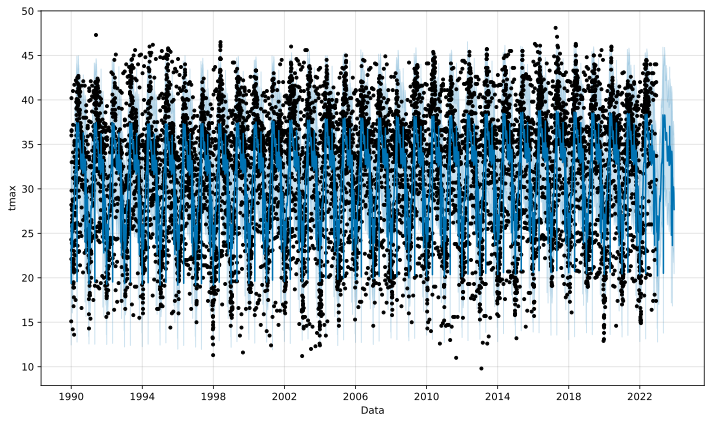

In [60]:
# visualizar o gráfico com as previsões
daily_model.plot(daily_forecast, xlabel='Data', ylabel='tmax');

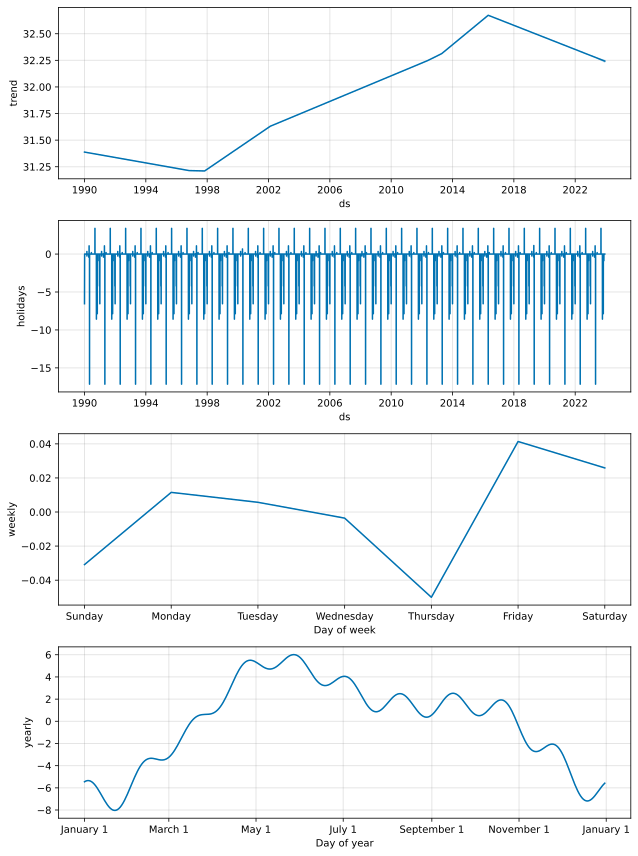

In [61]:
# separar os componentes do modelo
daily_model.plot_components(daily_forecast);

In [64]:
# criar um modelo baseado em semanas
weekly_prophet_df = df_limpo.resample('W').sum().reset_index().rename(columns={'time': 'ds', 'tmax': 'y'})

# instanciar e treinar o modelo
weekly_model = Prophet()
weekly_model.add_country_holidays(country_name='BR')
weekly_model.fit(weekly_prophet_df)

# determinar o período de dias para previsão
weekly_future = weekly_model.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
weekly_forecast = weekly_model.predict(weekly_future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppwtgoqli/pum47a5g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppwtgoqli/qup3uh4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47493', 'data', 'file=/tmp/tmppwtgoqli/pum47a5g.json', 'init=/tmp/tmppwtgoqli/qup3uh4e.json', 'output', 'file=/tmp/tmppwtgoqli/prophet_modelrhw44vkk/prophet_model-20221228191056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:10:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:10:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


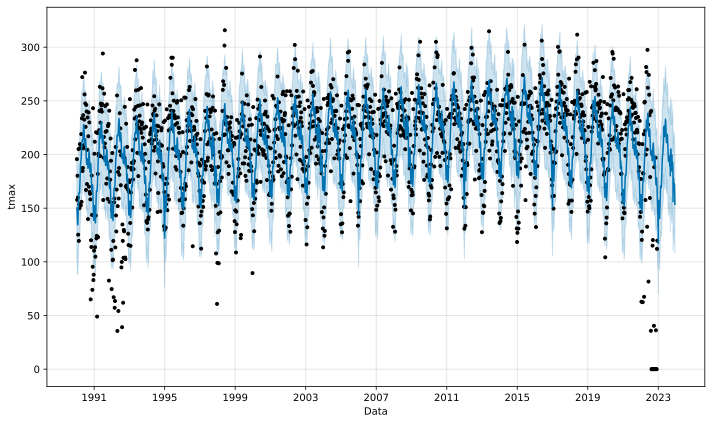

In [65]:
# visualizar o gráfico com as previsões
weekly_model.plot(weekly_forecast, xlabel='Data', ylabel='tmax');

In [ ]:
# criar dataframe de cross_validation
daily_df_cv = cross_validation(daily_model, horizon='180 days')
daily_df_cv.head()

In [67]:
# extrair métricas de desempenho
daily_df_p = performance_metrics(daily_df_cv)
daily_df_p.head()

horizon        mse      rmse       mae      mape     mdape     smape  \
0 19 days  30.971407  5.565196  4.211039  0.152669  0.100059  0.140644   
1 20 days  31.139936  5.580317  4.196742  0.151761  0.098713  0.139982   
2 21 days  31.754053  5.635073  4.224783  0.153052  0.097887  0.140934   
3 22 days  31.330822  5.597394  4.202535  0.151930  0.097828  0.140138   
4 23 days  31.189837  5.584786  4.200967  0.151579  0.097509  0.139952   

   coverage  
0  0.808101  
1  0.808710  
2  0.803949  
3  0.805081  
4  0.805812

In [71]:
# plotar gráfico
fig = plot_cross_validation_metric(daily_df_cv, metric='mse')

In [ ]:
weekly_df_cv = cross_validation(weekly_model, horizon='180 days')
weekly_df_cv.head()